Name : Anass El Moubaraki

University : Sorbonne (El Karoui program)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Exploratory data analysis

In [4]:
# Importing data
credit_data=pd.read_csv('Task 3 and 4_Loan_Data (1).csv')

In [5]:
# Checking missing values 
print(credit_data.isnull().sum())

customer_id                 0
credit_lines_outstanding    0
loan_amt_outstanding        0
total_debt_outstanding      0
income                      0
years_employed              0
fico_score                  0
default                     0
dtype: int64


We have no missing values whcih means that data is a priori clean.

In [7]:
# Statistical description of our data
print(credit_data.describe())

        customer_id  credit_lines_outstanding  loan_amt_outstanding  \
count  1.000000e+04              10000.000000          10000.000000   
mean   4.974577e+06                  1.461200           4159.677034   
std    2.293890e+06                  1.743846           1421.399078   
min    1.000324e+06                  0.000000             46.783973   
25%    2.977661e+06                  0.000000           3154.235371   
50%    4.989502e+06                  1.000000           4052.377228   
75%    6.967210e+06                  2.000000           5052.898103   
max    8.999789e+06                  5.000000          10750.677810   

       total_debt_outstanding         income  years_employed    fico_score  \
count            10000.000000   10000.000000    10000.000000  10000.000000   
mean              8718.916797   70039.901401        4.552800    637.557700   
std               6627.164762   20072.214143        1.566862     60.657906   
min                 31.652732    1000.000000    

A first analysis of the data shows that the output is not balanced. The main is around 0.18 which means we have more non default cases. Furthermore, a deep analysis of our inputs shows that data is tailed ( median different than mean ) especially for "total_debt_outstanding". That said the normality hypothesis does not hold for this variable. Let's take a look at the correlation matrix using seaborn package.

In [9]:
# Separing inputs from output
X=credit_data.drop(columns=['default','customer_id']).copy()
y=credit_data['default']

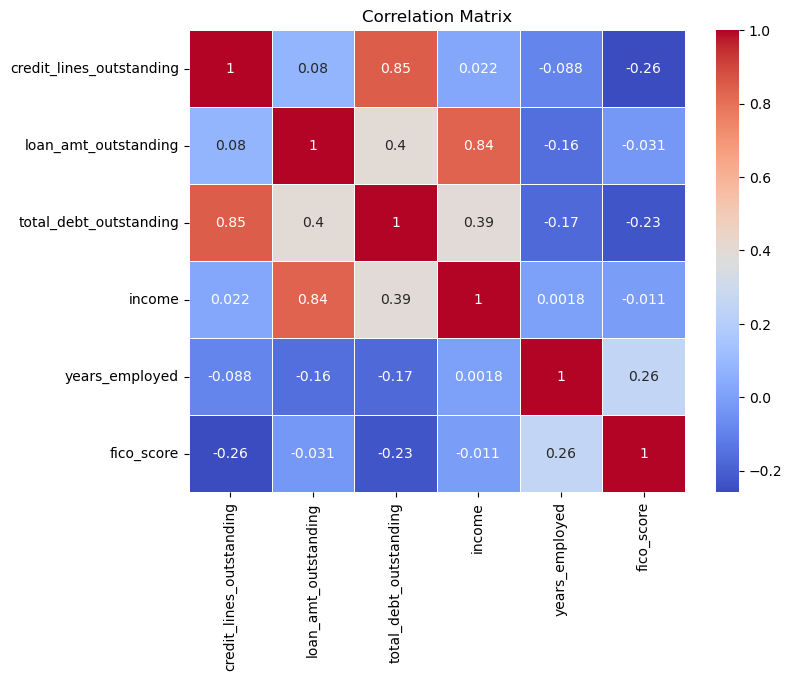

In [10]:
# Ploting correlation matrix between inputs
import seaborn as sns
corr_matrix=X.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

By analyzing the correlation matrix we can assume that "income" is strongly correlated to "loan_amt_outstanding" which is logical. The "credit_lines_outstanding" is also strongly correlated with "total_debt_outstanding". The results suggets that a dimensional reduction can be done under the normality hypothesis which is not valid . Honestly, comparing number of inputs with number of samples we don't really need dimensionality reduction. To visualise the effect of each input on the output we will apply a logistic regression, each time with one variable. This will give a better insight than a Pearson correlation. The latter is more adapted to continuous values.

In [12]:
## We normalize data before applying a logistic regression in order to detect the effect of each value ( have comparable beta ratios)
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X_scaled=scaler.fit_transform(X)

In [13]:
## Applying logistic regression to each variable
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
results=model.fit(X_scaled, y)
for i in range(len(X.columns)):
    print('La ponderation de la variable ' + X.columns[i] + ' est :', model.coef_[0][i])

La ponderation de la variable credit_lines_outstanding est : 13.646786149407617
La ponderation de la variable loan_amt_outstanding est : -0.2763932020317507
La ponderation de la variable total_debt_outstanding est : 4.803112809691472
La ponderation de la variable income est : -2.321143187549313
La ponderation de la variable years_employed est : -7.9337624158911
La ponderation de la variable fico_score est : -3.5772631535644193


We can deduce that the credit_line_outstanding variable and the total_debt_outstanding and strongly influences the log probability ratio. The bigger it is the larger is the probability of default (Risky client). Furthermore the larger is the fico score and the years employed the smaller is the probabilty of default (Non risky client). Now that we have used a very simple Logistic regression model to detect inputs influence let's build a strong model that can predict the default variable accurately. Regarding the huge amount of samples we have we can try an xgboost classifier without worrying about overfitting issues. The latter is a state of the art model in classification problems proven to be more robust than decision trees, random forests and logistic regression. To enhance robustness we will use a stacking strategy in order to combine different xgboost classifers performance with respect to their performance on unseen data. 

## Model building

In [16]:
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

## Defining our stacking classifier
def stacking_meta_model(list_n_estimators, list_max_depths, list_gammas):
    # Defining xgboost key caracteristics:
    # Max depths is the maximum depth of a decision tree used in the gradient boosting step 
    # Number of estimators is the number of decision trees used 
    # Gamma is a threshold which forces and additional value of gamma on the overall accuracy for any estimator we add.
    list_xgboost_models=[]
    n1,n2,n3=len(list_n_estimators),len(list_max_depths), len(list_gammas)
    for i in range(n1):
        for j in range(n2):
            for k in range(n3):
                model=XGBClassifier(objective='binary:logistic',n_estimators=list_n_estimators[i],learning_rate=0.1,max_depth=list_max_depths[j],gamma=list_gammas[k],random_state=42)
                list_xgboost_models.append((f'xgb{i}{j}{k}', model))
    # Level-1 stacking classifier with 5 cross validations on each Level-0 metamodel
    stacking_classifier= StackingClassifier(estimators=list_xgboost_models,final_estimator=LogisticRegression(),cv=5)
    return stacking_classifier

In [17]:
# Testing our model 
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, shuffle=False)

In [18]:
model=stacking_meta_model(list_n_estimators=[50,75,100], list_max_depths=[3,6,9], list_gammas=[0, 0.01, 0.05])

In [19]:
import time
start_time=time.time()
model.fit(X_train,y_train)
end_time=time.time()
print(end_time-start_time)

24.56725525856018


In [20]:
# We calculate prediction accuracy
y_pred=model.predict(X_test)
accuracy=accuracy_score(y_test,y_pred)
print('The accuracy score is :', accuracy)

The accuracy score is : 0.9955


 Let's calculate the confusion matrix to see wether the model is able to detect default cases as good as non default. In our case, this step is necessary because our data is not equilibrated. 

In [22]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1622    5]
 [   4  369]]


Our model is accurate 99% of the time and the confusion matrix is equilibrated which means that the model does not predict well one class and neglicts the other. The model detects a true positif with over 98% accuracy. To verify that it is not overfitting let's activate shuffle button on train test split so that it selects randomly test data and train data and take a look at the distribution of accuracy. This step will take some time but it is worth trying.

In [24]:
nbr_random_shuffles=10
liste_accuracys=[]
true_positive_rates=[]
for i in range(nbr_random_shuffles):
    X_train_1,X_test_1,y_train_1,y_test_1=train_test_split(X, y, test_size=0.2, shuffle=True)
    model.fit(X_train_1,y_train_1)
    y_pred_1=model.predict(X_test_1)
    accuracy=accuracy_score(y_test_1,y_pred_1)
    cm = confusion_matrix(y_test_1, y_pred_1)
    liste_accuracys.append(accuracy)
    true_positive_rates.append(cm[1][1]/(cm[1][1]+cm[1][0]))

In [25]:
print(liste_accuracys)
print(true_positive_rates)

[0.9955, 0.9965, 0.9945, 0.997, 0.9975, 0.9935, 0.9945, 0.996, 0.997, 0.9975]
[0.9895833333333334, 0.992, 0.9868073878627969, 0.9883040935672515, 0.996969696969697, 0.9890710382513661, 0.9917582417582418, 0.9830028328611898, 0.9894736842105263, 0.9973404255319149]


## Conclusion

The model we constructed is very effective. In fact, the accuracys are all above 99%. However the training take 20 seconds, if that is acceptable in term of temporal complexity then the model is very effective.